In [13]:
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Latex

plt.style.use('ggplot')

In [14]:
ALPHA = 0.05

In [5]:
df = pd.read_csv('IB_statistics_data_hw2.8.txt', sep=' ')
df.head()

,Ex1,Ex1_group,Ex2,Ex2_group,Ex4,Ex4_group
0,4.046259,1,-0.703409,1,0.329606,1
1,0.785765,1,5.007998,1,0.717503,1
2,-3.683268,1,-2.702688,1,0.081047,1
3,1.853011,1,2.969791,1,1.418377,1
4,0.299360,1,-2.023888,1,0.394656,1


---
---

# 1

In [18]:
group1 = df.query('Ex1_group == 1')['Ex1']
group2 = df.query('Ex1_group == 2')['Ex1']


T_ind, p_ind = sp.stats.ttest_ind(group1, group2)  # независимы
T_dep, p_dep = sp.stats.ttest_rel(group1, group2)  # зависимы

print('Если считать выборки независимыми:')
display(Latex(f'$T = {T_ind}, p = {p_ind}$'))
print('Если считать выборки зависимыми:')
display(Latex(f'$T = {T_dep}, p = {p_dep}$'))

Если считать выборки независимыми:


<IPython.core.display.Latex object>

Если считать выборки зависимыми:


<IPython.core.display.Latex object>

В обоих случаях нулевая гипотеза отклоняется.

# 2

In [27]:
sp.stats.f_oneway(*[df.query('Ex2_group == @i')['Ex2'] for i in range(1, 5)])

F_onewayResult(statistic=0.9173732401574869, pvalue=0.43340533054551933)

$p > 0.05$, нулевая гипотеза не отклоняется.

# 3

Построим матрицу плана и припишем к ней ограничение на оценки:

In [238]:
n_groups = 4
y = df['Ex2'].to_numpy()
X = np.zeros(shape=(df.shape[0], n_groups))

for i in range(1, n_groups+1):
    X[:, i-1] = np.where(df['Ex2_group'] == i, 1, 0)
X = np.insert(X, 0, 1, axis=1)  # добавить интерсепт
print('Матрица плана:')
display(X)

# добавить ограничение
y = np.insert(y, len(y), 0)
X = np.insert(X, X.shape[0], [0] + [1] * n_groups, axis=0)
print('Ограничение:')
print(y[-1], ';', X[-1])

Матрица плана:


array([[1., 1., 0., 0., 0.],
       [1., 1., 0., 0., 0.],
       [1., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 1.],
       [1., 0., 0., 0., 1.],
       [1., 0., 0., 0., 1.]])

Ограничение:
0.0 ; [0. 1. 1. 1. 1.]


In [256]:
beta = np.linalg.lstsq(X, y, rcond=None)[0]
assert beta[1:].sum() < 1e-8  # проверка условия...
display(Latex(r'$\hat{\beta} =$'))
display(beta)

# МНК-оценка дисперсии ошибок
n = X.shape[0] - 1
m = X.shape[1] - 1
s2 = np.sum((y - X @ beta)**2) / (n - m)
display(Latex(fr'$s^2 = {round(s2, 3)}$'))

<IPython.core.display.Latex object>

array([ 0.27479218,  0.31681858, -0.49311363, -0.48929791,  0.66559297])

<IPython.core.display.Latex object>

In [285]:
beta_H0 = np.array([1, 0, 0, 0, 0])
T = (y[:-1] - X[-1:, :] @ beta_H0).T @ (y[:-1] - X[:-1, :] @ beta_H0) / s2
# вместо ковариационной матрицы у нас по сути используется её оценка
# поэтому число степеней свободы по идее должно быть больше на "число неизвестных параметров"
# т.е. на 1 - дисперсию, которую мы оцениваем...
p_value = 1 - sp.stats.chi2(X[:-1].shape[0] + 1).cdf(T)  
p_value

0.5589750358836867

$p > 0.05$, нулевая гипотеза не отвергается.

# 4

In [390]:
np.random.seed(0)

group_sizes = df['Ex4_group'].value_counts()
n_groups = len(group_sizes)

N = 10000  # число итераций бутстрепа

# расчёт статистики - дисперсия вектора средних
T = np.var([df.query('Ex4_group == @gr')['Ex4'].mean() for gr in group_sizes.index])

values = df['Ex4']
bootstrap_T = np.zeros(N)
for i in range(N):
    bootstrap_T[i] = np.var([values.sample(n=group_size, replace=True).mean() for group_size in group_sizes])
 
bootstrap_T = np.sort(bootstrap_T)

<IPython.core.display.Latex object>

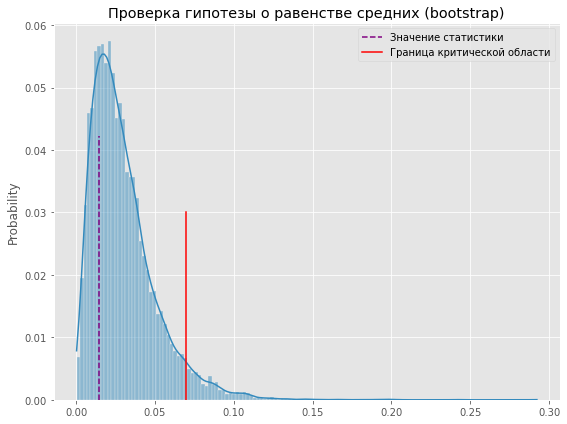

In [391]:
right = bootstrap_T[int(N * (1 - ALPHA))]  # граница критической области
p_value = 1 - np.searchsorted(bootstrap_T, T) / N

fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(bootstrap_T, stat='probability', ax=ax, kde=True)

# ax.vlines([right, T], 0, 0.2, label=['Граница критической области', 'Статистика'])
ax.axvline(T, 0, 0.7, color='purple', label='Значение статистики', linestyle='dashed')
ax.axvline(right, 0, 0.5, color='red', label='Граница критической области')
ax.legend()
ax.set_title('Проверка гипотезы о равенстве средних (bootstrap)')
display(Latex(rf'$p = {round(p_value, 3)}$'))
fig.tight_layout()

Нулевая гипотеза не отвергается.

# 5

In [443]:
def generate_plan_matrix(sizes):
    # в переменных index1 будем запоминать, насколько далеко мы уже продвинулись
    # в заполнении блоков матрицы плана, отвечающих за разбиение по первому 
    # и по второму фактору соответственно.
    # 
    # e.g. после заполнения первого столбца единичек index1 будет равен [1, sizes[0, 1]]
    # аналогично с index2, только его столбцы должны начинаться с r, 
    # т.к. столбцы с индексами 0, ..., r-1 отведены под первый фактор
    r, s = sizes.shape
    pm = np.zeros(shape=(sizes.sum(), r + s))
    index1 = [0, 0]           
    index2 = [0, r]
    for i in range(r):
        index2 = [index2[0], r]
        num_of_obs = np.sum(sizes[i])
        pm[index1[0]:index1[0]+num_of_obs, index1[1]] = 1
        index1[0] += num_of_obs
        index1[1] += 1
        for j in range(s):
            num_of_obs = sizes[i, j]
            pm[index2[0]:index2[0]+num_of_obs, index2[1]] =1
            index2[0] += num_of_obs
            index2[1] += 1
    # добавить столбец единичек
    return np.insert(pm, 0, 1, axis=1)

test1 = np.array([
    [2, 2, 2],
    [2, 2, 0]
])
test2 = np.array([
    [2, 2,],
    [2, 2],
    [1, 2]
])
display(generate_plan_matrix(test1))
display(generate_plan_matrix(test2))

array([[1., 1., 0., 1., 0., 0.],
       [1., 1., 0., 1., 0., 0.],
       [1., 1., 0., 0., 1., 0.],
       [1., 1., 0., 0., 1., 0.],
       [1., 1., 0., 0., 0., 1.],
       [1., 1., 0., 0., 0., 1.],
       [1., 0., 1., 1., 0., 0.],
       [1., 0., 1., 1., 0., 0.],
       [1., 0., 1., 0., 1., 0.],
       [1., 0., 1., 0., 1., 0.]])

array([[1., 1., 0., 0., 1., 0.],
       [1., 1., 0., 0., 1., 0.],
       [1., 1., 0., 0., 0., 1.],
       [1., 1., 0., 0., 0., 1.],
       [1., 0., 1., 0., 1., 0.],
       [1., 0., 1., 0., 1., 0.],
       [1., 0., 1., 0., 0., 1.],
       [1., 0., 1., 0., 0., 1.],
       [1., 0., 0., 1., 1., 0.],
       [1., 0., 0., 1., 0., 1.],
       [1., 0., 0., 1., 0., 1.]])

# 6

Построить вектор параметров минимальной нормы можно, используя псевдообратную матрцу.

In [458]:
group_sizes = np.array([
    [12, 20, 8, 0],
    [30, 24, 11, 7]
])

X = generate_plan_matrix(group_sizes)
X

array([[1., 1., 0., 1., 0., 0., 0.],
       [1., 1., 0., 1., 0., 0., 0.],
       [1., 1., 0., 1., 0., 0., 0.],
       [1., 1., 0., 1., 0., 0., 0.],
       [1., 1., 0., 1., 0., 0., 0.],
       [1., 1., 0., 1., 0., 0., 0.],
       [1., 1., 0., 1., 0., 0., 0.],
       [1., 1., 0., 1., 0., 0., 0.],
       [1., 1., 0., 1., 0., 0., 0.],
       [1., 1., 0., 1., 0., 0., 0.],
       [1., 1., 0., 1., 0., 0., 0.],
       [1., 1., 0., 1., 0., 0., 0.],
       [1., 1., 0., 0., 1., 0., 0.],
       [1., 1., 0., 0., 1., 0., 0.],
       [1., 1., 0., 0., 1., 0., 0.],
       [1., 1., 0., 0., 1., 0., 0.],
       [1., 1., 0., 0., 1., 0., 0.],
       [1., 1., 0., 0., 1., 0., 0.],
       [1., 1., 0., 0., 1., 0., 0.],
       [1., 1., 0., 0., 1., 0., 0.],
       [1., 1., 0., 0., 1., 0., 0.],
       [1., 1., 0., 0., 1., 0., 0.],
       [1., 1., 0., 0., 1., 0., 0.],
       [1., 1., 0., 0., 1., 0., 0.],
       [1., 1., 0., 0., 1., 0., 0.],
       [1., 1., 0., 0., 1., 0., 0.],
       [1., 1., 0., 0., 1., 0., 0.],
 